# Blue Book for Bulldozers

## Define the Problem
Given the characteristics of a heavy equipment like a bulldozer, and given previous examples of similar bulldozers and their prices, predict the sale price of the bulldozer you are currently assessing. This is a regression ML task under a time series component. 

## Define Data to Use
This dataset is from [Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers)
 
> The data for this competition is split into three parts:

    - Train.csv is the training set, which contains data through the end of 2011.
    - Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
    - Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.



## Define Evaluation Metrics
> The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

> Sample submission files can be downloaded from the data page. Submission files should be formatted as follows:

    - Have a header: "SalesID,SalePrice"
    - Contain two columns
        - SalesID: SalesID for the validation set in sorted order
        - SalePrice: Your predicted price of the sale

Example lines of the submission format:

- SalesID,SalePrice
- 1222837,36205
- 3044012,74570
- 1222841,31910.50
... 

* The goal is to minimize the RMSE. 


## Define Features

Kaggle provides a data dictionary detailing all features of the dataset. You can view this data by importing into a Google Sheet.

## Import Tools

In [1]:
import glob
import zipfile
from os import walk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

## Load Data

In [2]:
# get zipped folder
data_path = 'data/bluebook-for-bulldozers.zip'
files = glob.glob(data_path)

# unzip the folder
for file in files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall("data/")

In [3]:
# check what files + dirs you got
f = []
for (dirpath, dirnames, filenames) in walk("data/bluebook-for-bulldozers"):
    f.extend(filenames)
    break

f

['Data Dictionary.xlsx',
 'Machine_Appendix.csv',
 'median_benchmark.csv',
 'random_forest_benchmark_test.csv',
 'Test.csv',
 'test_predictions.csv',
 'Train.7z',
 'Train.csv',
 'Train.zip',
 'TrainAndValid.7z',
 'TrainAndValid.csv',
 'TrainAndValid.zip',
 'train_tmp.csv',
 'Valid.7z',
 'Valid.csv',
 'Valid.zip',
 'ValidSolution.csv']

In [4]:
# import train and validation sets
df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False)
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [6]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

Damn-- that's alot to impute.

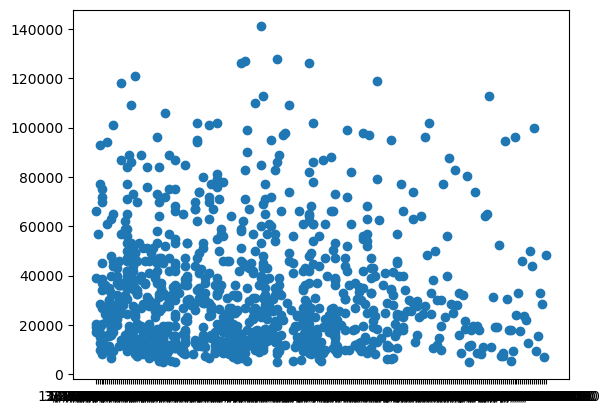

In [7]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

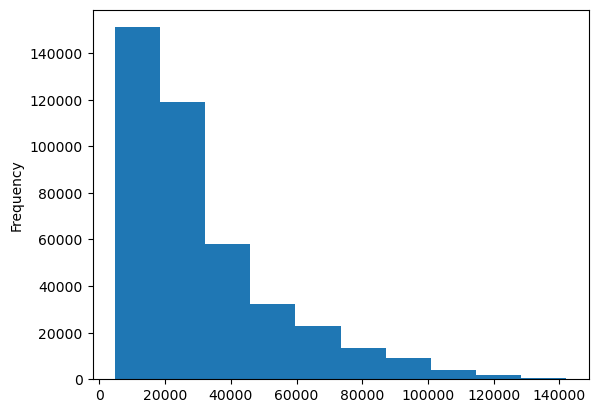

In [8]:
df.SalePrice.plot.hist();

Most of the sales are made under $20k. This is very right-tail skewed. 

### Parsing Dates

When working with time series data, you want to enrich the time and date component as much as possible. We want to do that by telling pandas which columns has dates in it using the `parse_dates` 

In [9]:
df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,2012-03-07,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,2012-01-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,2012-01-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,2012-03-07,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


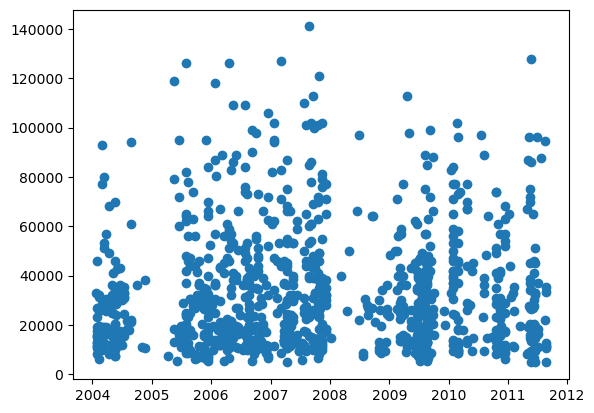

In [10]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

#### Sort DataFrame by SaleDate

When working with time series data, it's a good idea to sort it by date

In [11]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

#### Make Copy of the Original, Work on the Copy

You don't want to mess with the OG in case you mess something up.

In [12]:
df_tmp = df.copy()

## Data Cleaning

### Enrich data with date

#### Add datetime parameters for `saledate` column

In [13]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

#### Remove saledate column
Since we just enriched the data with datetime features, we don't need the OG column

In [14]:
df_tmp.drop('saledate', axis=1, inplace=True)

In [15]:
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## Preprocess

### Convert String +  Objects to Categorical Variables

In [18]:
pd.api.types.is_object_dtype(df_tmp["UsageBand"])

True

In [19]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
        df_tmp[label] = content.astype("category").cat.as_ordered()

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [20]:
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)
        df_tmp[label] = content.astype("category").cat.as_ordered()

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [21]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [22]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

### Fill Missing Values

In [23]:
# to check how much (in percentage) are there missing values in each column
(df_tmp.isnull().sum() / len(df_tmp)) * 100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

#### Fill Numerical Columns' Missing Values

In [24]:
# fill missing rows with median value
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # add a binary column to tell if data was missing
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            # fill with median b/c median more robust than the mean (esp. if you have have a lot samples)
            df_tmp[label] = content.fillna(content.median()) 

In [25]:
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

This means we just filled 20136 missing values. 

#### Fill Categorical Variables' Their Missing Values

In [27]:
# Turn categorical variables into numbers
for label, content in df_tmp.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(content).codes+1     

In [28]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


## Model

### Split

In [29]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

X_train, y_train = df_train.drop("SalePrice", axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Baseline Fit

#### Create Own Evaluation Metrics & RMSLE (root mean squared log error)

In [33]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
        Calculate root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": {mean_absolute_error(y_train, train_preds)},
             "Valid MAE": {mean_absolute_error(y_valid, val_preds)},
             "Training RMSLE": {rmsle(y_train, train_preds)},
             "Valid RMSLE": {rmsle(y_valid, val_preds)},
              "Training R_squared": {model.score(X_train, y_train)},
              "Valid R_squared": {model.score(X_valid, y_valid)}
             }
    return scores

#### Test model on a subset of data (to tune hyperparams)

In [34]:
# fitting the entire 400k dataset is going to take too long.

# model = RandomForestRegressor(n_jobs=-1, random_state=42)
# model.fit(X_train, y_train)
# show_scores(model)

%time

# Cutting down the max_samples for each n_estimator can improve training time
print(f"Training on 10000 samples with 100 n_estimators should cut down time by {X_train.shape[0] * 100 / (10000 * 100)}x.")
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)
model.fit(X_train, y_train)
show_scores(model)

CPU times: total: 0 ns
Wall time: 0 ns
Training on 10000 samples with 100 n_estimators should cut down time by 40.1125x.


{'Training MAE': {5561.2988092240585},
 'Valid MAE': {7177.26365505919},
 'Training RMSLE': {0.257745378256977},
 'Valid RMSLE': {0.29362638671089003},
 'Training R_squared': {0.8606658995199189},
 'Valid R_squared': {0.8320374995090507}}

## Tuning

In [37]:
%time
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt", "auto"],
    "max_samples": [10000]
}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                             param_distributions=rf_grid,
                             n_iter=2,
                              cv=5,
                             verbose=True)

rs_model.fit(X_train, y_train)
show_scores(rs_model)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\katie\anaconda3\envs\ml_basics\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

{'Training MAE': {5953.6403918527},
 'Valid MAE': {7484.0581543881135},
 'Training RMSLE': {0.27070502037430516},
 'Valid RMSLE': {0.3028191539132065},
 'Training R_squared': {0.8388349052090136},
 'Valid R_squared': {0.8120158136485638}}

In [38]:
rs_model.best_params_

{'n_estimators': 20,
 'min_samples_split': 16,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

### Best params

These were found after 100 iterations of RandomizedSearchCV by Daniel Bourke.

In [39]:
%time

# most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=1,
                                   min_samples_split=14,
                                   max_features=0.5,
                                   n_jobs=-1,
                                   max_samples=None)

ideal_model.fit(X_train, y_train)
show_scores(ideal_model)

CPU times: total: 0 ns
Wall time: 0 ns


{'Training MAE': {2954.8391173808577},
 'Valid MAE': {5947.106273229046},
 'Training RMSLE': {0.14456401415859715},
 'Valid RMSLE': {0.24641698870788592},
 'Training R_squared': {0.9589081568397565},
 'Valid R_squared': {0.8816739205377325}}

## Test Model

In [54]:
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv", low_memory=False, parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocess the test dataset

You have to preprocess the test dataset before making predictions.

In [55]:
def preprocess_data(df):
    """
        Does transformations on df, and returns transformed df.
    """
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # add a binary column to tell if data was missing
                df[label + "_is_missing"] = pd.isnull(content)
                # fill with median b/c median more robust than the mean (esp. if you have have a lot samples)
                df[label] = content.fillna(content.median()) 
                
    # fill categorical missing data, and turned categories into numbers
    for label, content in df.items():
        # Check columns which *aren't* numeric
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to inidicate whether sample had missing value
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1 
    
    return df

The columns between test and train sets are different by 1. So you'll have to bring that 1 column back.

In [56]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [57]:
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

Manually adjust df_test to have auctioneerID_is_missing columns

In [58]:
X_train_list = X_train.columns.values.tolist()

In [59]:
print(X_train_list.index("auctioneerID_is_missing"))

56


In [60]:
print(len(df_test))

12457


In [61]:
df_test.insert(X_train_list.index("auctioneerID_is_missing"), "auctioneerID_is_missing", [False]*len(df_test))
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [62]:
# Make Prediction on test dataset
test_preds = ideal_model.predict(df_test)
test_preds

array([18567.62206178, 15969.29588623, 53481.31338114, ...,
       15206.54499945, 17445.60563314, 29020.02773411])

#### Format predictions into a dataframe that Kaggle wants 


In [63]:
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test["SalesID"]
df_preds['SalesPrice'] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,18567.622062
1,1227844,15969.295886
2,1227847,53481.313381
3,1227848,59746.316923
4,1227863,52409.509780
...,...,...
12452,6643171,41531.836909
12453,6643173,13721.719045
12454,6643184,15206.544999
12455,6643186,17445.605633


### Export Prediction Data

In [64]:
df_preds.to_csv("data/bluebook-for-bulldozers/my_test_predictions.csv", index=False)

## Feature Importance

In [67]:
ideal_model.feature_importances_

array([3.24767581e-02, 2.17713026e-02, 4.50126864e-02, 1.75464460e-03,
       3.39874324e-03, 2.05130896e-01, 3.23541803e-03, 1.03983840e-03,
       3.75934080e-02, 4.17478962e-02, 6.39284585e-02, 4.95569116e-03,
       1.92189006e-02, 1.38553874e-01, 4.01810171e-02, 5.99298527e-03,
       4.09374112e-03, 3.37978802e-03, 3.08397382e-03, 6.35807323e-02,
       3.99176989e-04, 4.82862221e-05, 9.26217439e-04, 1.98306255e-04,
       9.74084815e-04, 3.48457182e-04, 5.60548564e-04, 8.60600582e-03,
       2.20878402e-04, 1.89548219e-04, 6.53117656e-03, 9.73792311e-03,
       5.97933366e-03, 5.03740234e-03, 3.05431209e-04, 7.48808059e-03,
       8.94451288e-04, 1.01043828e-02, 3.45511559e-03, 3.54886114e-06,
       1.50900124e-03, 8.58450597e-04, 2.32106178e-03, 5.87234168e-04,
       5.33954843e-04, 3.56919625e-04, 2.78564278e-04, 2.80361596e-03,
       1.45798605e-03, 2.63670520e-04, 2.14163294e-04, 7.29431687e-02,
       3.82212013e-03, 5.65428258e-03, 2.85945638e-03, 9.78447215e-03,
      

In [70]:
def plot_feature_importance(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

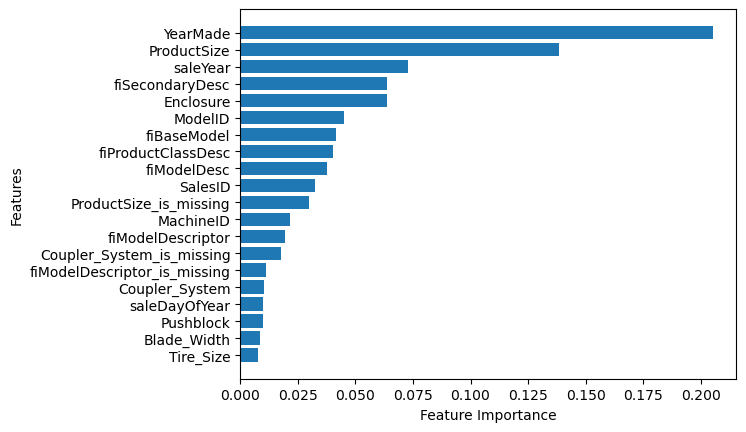

In [71]:
plot_feature_importance(X_train.columns, ideal_model.feature_importances_)

In [73]:
df["ProductSize"].value_counts()

ProductSize
Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: count, dtype: int64